In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
# Librerías para visualizacion
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import re
import networkx as nx
from itertools import count
from itertools import combinations
from itertools import product
import statsmodels.api as sm
import urllib.request, json
!pip3 install geopandas
import geopandas
# -- set scientific notation to display numbers fully rather than exponential
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
import seaborn as sns
sns.set_style('whitegrid') # grids en dark background

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',300)
print('librerías cargadas')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.2 MB/s eta 0:00:00
librerías cargadas


#¿Qué es PRODY?

This is a measure calculated as the GDP per
capita of countries that produce it, weighted by their revealed comparative advantage in
that product.

Se importa la base desde drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
## Se importa la base de exportaciones de productos drive
df = pd.read_csv("/content/drive/MyDrive/eci/base/df_updated.csv")
print('dataframe cargado')

dataframe cargado


In [5]:
df.sample(n=6)
df.info()

,year,country_code,country_name,product_code,product_name,export_value
3419809,1999,TUN,Tunisia,4911,"Printed matter, n.e.s., including printed pictures and photographs",722433
2165813,2011,BEN,Benin,3005,"Wadding, gauze, bandages (dressings, adhesive plasters, poultices), impregnated or coated with pharmaceutical substances or in forms or packings for retail sale, for medical, surgical or veterinary use",73358
4629311,1996,AND,Andorra,7006,"Glass of heading no. 7003, 7004 or 7005, bent, edge-worked, engraved, drilled, enamelled or otherwise worked, not framed or fitted with other materials",0
6083011,2001,NIU,Niue,8456,"Machine-tools; for working any material by removal of material, by laser, other light or photon beam, ultrasonic, electro-discharge, electro-chemical, electron beam, ionic beam or plasma arc processes",0
2443208,2006,NER,Niger,3604,"Fireworks, signalling flares, rain rockets, fog signals and other pyrotechnic articles",0
5764620,2016,CYM,Cayman Islands,8403,Central heating boilers; excluding those of heading no. 8402,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7373271 entries, 0 to 7373270
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   year          int64 
 1   country_code  object
 2   country_name  object
 3   product_code  int64 
 4   product_name  object
 5   export_value  int64 
dtypes: int64(3), object(3)
memory usage: 337.5+ MB


In [ ]:
df['country_name'].nunique()

242

#Calculo de RCA

In [6]:
## Función para el cálculo de RCA

def calc_rca(data,pais_col,prod_col,anio_col,value_col):
    """
      La función que calcula la RCA
    
    """
    print('Creando las combinaciones de país-producto-tiempo')
    df_all = pd.DataFrame(list(product(data[anio_col].unique(), data[pais_col].unique(),data[prod_col].unique())))
    df_all.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    df_all = pd.merge(df_all,data[[anio_col,pais_col,prod_col,value_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # En esta parte se calculan propiedades del RCA
    print('calculando')
    df_all['Xcpt'] = df_all[value_col]
    df_all['Xct'] = df_all.groupby([pais_col, anio_col])[value_col].transform(sum)
    df_all['Xpt'] = df_all.groupby([prod_col, anio_col])[value_col].transform(sum)
    df_all['Xt'] = df_all.groupby([anio_col])[value_col].transform('sum')

    df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt']) #--> ecuación de las ventaja comparativa revelada RCA
    
    ## 0 si el producto / país tiene 0 exportaciones
    df_all.loc[df_all['RCAcpt'].isnull(),'RCAcpt'] = 0 
    # drop the properties 
    df_all.drop(['Xcpt','Xct','Xpt','Xt'],axis=1,inplace=True,errors='ignore')

    return df_all


In [7]:
df_rca = calc_rca(data=df,pais_col='country_name',prod_col='product_name',anio_col='year',value_col='export_value')

print('rca listo!!')

# Se muestran resultados
df_rca[0:10]

Creando las combinaciones de país-producto-tiempo
Se procede a fusionar los datos
calculando
rca listo!!


,year,country_name,product_name,export_value,RCAcpt
0,1995,Aruba,"Horses, asses, mules and hinnies; live",18008.00,0.13
1,1995,Aruba,Bovine animals; live,0.00,0.00
2,1995,Aruba,Swine; live,0.00,0.00
3,1995,Aruba,Sheep and goats; live,0.00,0.00
4,1995,Aruba,"Poultry; live, fowls of the species gallus domesticus, ducks, geese, turkeys and guinea fowls",0.00,0.00
5,1995,Aruba,"Animals, n.e.s. in chapter 01; live",2336.00,0.05
6,1995,Aruba,Meat of bovine animals; fresh or chilled,0.00,0.00
7,1995,Aruba,Meat of bovine animals; frozen,0.00,0.00
8,1995,Aruba,"Meat of swine; fresh, chilled or frozen",0.00,0.00
9,1995,Aruba,"Meat of sheep or goats; fresh, chilled or frozen",0.00,0.00


In [12]:
df_rca['product_name'].nunique()
 # en These data are drawn from the United Nations Commodity Trade Statistics, and
# available from 1962-2000 at the SITC 4-digit level of desegregation (1006 products)

1242

###Se filtra el dataframe solo para Ecuador

In [8]:

# Ecuador
df_rca[ (df_rca['country_name']=='Ecuador')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:10]


,product_name,RCAcpt,year
2176048,"Bananas, including plantains; fresh or dried",266.11,2002
2476612,"Bananas, including plantains; fresh or dried",245.41,2003
1875484,"Bananas, including plantains; fresh or dried",244.05,2001
1574920,"Bananas, including plantains; fresh or dried",241.97,2000
1274356,"Bananas, including plantains; fresh or dried",234.63,1999
6384612,"Hat-shapes; plaited or made by assembling strips of any material, neither blocked to shape, nor with made brims, nor lined, nor trimmed",233.22,2016
6383944,"Bananas, including plantains; fresh or dried",231.67,2016
673228,"Bananas, including plantains; fresh or dried",229.02,1997
6684508,"Bananas, including plantains; fresh or dried",227.59,2017
6985072,"Bananas, including plantains; fresh or dried",225.52,2018


#Cálculo con PPP del Banco Mundial

In [ ]:
## Se importa la base de gdp percapita de todos los países desde el drive
df_gdppc_countries = pd.read_csv("/content/drive/MyDrive/eci/base/gpd_per_capita_countries_db.csv").copy()
print('dataframe del gpd cargado')

dataframe del gpd cargado


In [ ]:
df_gdppc_countries[0:3]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6283.00,7567.25,9274.51,10767.40,11638.73,12850.22,13657.67,14970.15,16675.28,17140.43,17375.23,18713.43,19742.32,19833.83,21023.16,20913.30,21377.10,22050.83,24104.65,24975.67,25833.45,27665.43,29011.56,25739.14,24452.93,26044.44,25609.96,26515.68,26942.31,28421.39,28451.27,29326.71,30220.59,31650.76,24487.86,29342.10
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,162.91,162.55,172.00,199.18,179.38,198.22,209.41,211.70,224.23,249.58,260.11,278.75,293.08,370.41,444.72,459.90,444.08,489.85,530.37,600.37,738.87,732.92,681.65,691.99,615.41,508.69,552.54,654.32,697.22,722.43,817.15,858.30,728.77,704.74,697.18,762.84,739.47,757.85,696.37,669.69,706.99,628.20,626.56,812.95,985.53,1120.45,1226.18,1369.81,1428.33,1411.58,1643.55,1792.85,1760.22,1731.80,1719.81,1540.85,1432.11,1613.79,1550.18,1500.23,1353.77,1537.34
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,62.37,62.44,60.95,82.02,85.51,105.24,143.10,167.17,134.01,134.25,162.64,166.22,141.37,149.74,181.60,194.67,205.67,232.78,255.05,284.76,291.65,311.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.53,200.46,221.66,255.06,274.00,375.08,387.85,443.85,554.60,621.91,663.14,651.99,628.15,592.48,520.25,530.15,502.06,500.52,516.87,368.75


In [ ]:
## Se modifica la base de gdp per capita con los datos que solo nos interesan
df_gdppc = df_gdppc_countries.filter(items=['Country Name','Country Code','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']).copy()
df_gdppc=df_gdppc.rename(columns={"Country Name": "country_name", "Country Code": "country_code"}).copy()
df_gdppc=df_gdppc.melt(id_vars=["country_name", "country_code"], 
        var_name="year", 
        value_name="Value").copy()
df_gdppc=df_gdppc.rename(columns={"Value": "gdp_per_capita"}).copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Latin America & the Caribbean (IDA & IBRD countries)' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Europe & Central Asia (excluding high income)' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'World' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Fragile and conflict affected situations'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Pacific island small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'OECD members'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Caribbean small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Heavily indebted poor countries (HIPC)'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'East Asia & Pacific (excluding high income)'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Europe & Central Asia (IDA & IBRD countries)'].copy()
df_gdppc =  df_gdppc.loc[(df_gdppc["country_name"] != 'Lower middle income') & (df_gdppc["country_name"] != 'IBRD only')& (df_gdppc["country_name"] != 'IDA total') & (df_gdppc["country_name"] != 'East Asia & Pacific')
&(df_gdppc['country_name']!='Sub-Saharan Africa (excluding high income)')&(df_gdppc['country_name']!='Low & middle income')&(df_gdppc['country_name']!='Not classified')
&(df_gdppc['country_name']!='Middle East & North Africa (IDA & IBRD countries)')&(df_gdppc['country_name']!='Post-demographic dividend')&(df_gdppc['country_name']!='Latin America & Caribbean')
&(df_gdppc['country_name']!='Middle income')&(df_gdppc['country_name']!='East Asia & Pacific (IDA & IBRD countries)')&(df_gdppc['country_name']!='IDA & IBRD total') &(df_gdppc['country_name']!='South Asia (IDA & IBRD)')
&(df_gdppc['country_name']!='South Asia')
&(df_gdppc['country_name']!='Least developed countries: UN classification')].copy()
## Se reemplaza actualiza los nombres de paises de la base del Banco Mundial para igualarlos con los de la base CONTRADE
df_gdppc=df_gdppc.replace("Korea, Dem. People's Rep.", "North Korea").copy()
df_gdppc=df_gdppc.replace("Korea, Rep.", "South Korea").copy()
df_gdppc=df_gdppc.replace("Cote d'Ivoire", "Côte d'Ivoire").copy()
df_gdppc=df_gdppc.replace("Congo, Dem. Rep.", "Congo (Democratic Republic of the)").copy()
df_gdppc=df_gdppc.replace("Congo, Rep.", "Congo").copy()
df_gdppc=df_gdppc.replace("Curacao", "Curaçao").copy()
df_gdppc=df_gdppc.replace("British Virgin Islands","Virgin Islands (British)").copy()
df_gdppc=df_gdppc.replace("Egypt, Arab Rep.","Egypt").copy()
df_gdppc=df_gdppc.replace("Hong Kong SAR","Hong Kong").copy()
df_gdppc=df_gdppc.replace("United States","United States of America").copy()
df_gdppc=df_gdppc.replace("St. Vincent and the Grenadines","Saint Vincent and the Grenadines").copy()
df_gdppc=df_gdppc.replace("Venezuela, RB","Venezuela").copy()







# df_gdppc = df_gdppc.drop(df_gdppc.index[3254]).copy()
# df_gdppc = df_gdppc.drop(df_gdppc.index[3522]).copy() #Europe & Central Asia (excluding high income)
# df_gdppc = df_gdppc.drop(df_gdppc.index[1162]).copy() #Heavily indebted poor countries (HIPC)	
# df_gdppc = df_gdppc.drop(df_gdppc.index[[3960,3965,134,4703,1579,5193,2092,2454,449,3407,1395,1204,191,4143,1394,3993,3096,1527,3254,3522,1162,3428,4132,4454]]).copy() #Heavily indebted poor countries (HIPC),	Latin America & the Caribbean (IDA & IBRD countries)	
df_gdppc["year"]=df_gdppc["year"].astype(np.int64).copy()



df_gdppc.sample(n=10)
df_gdppc.shape
df_gdppc.info()
#World
#Fragile and conflict affected situations
#East Asia & Pacific (excluding high income)
#Pacific island small states

,country_name,country_code,year,gdp_per_capita
3617,Malta,MLT,2013,24770.93
4814,Belize,BLZ,2018,6059.16
3763,Chile,CHL,2014,14666.34
944,"Macao SAR, China",MAC,2003,17829.05
647,Israel,ISR,2002,19035.10
4466,Sierra Leone,SLE,2016,490.37
443,Norway,NOR,2001,38542.72
5160,Indonesia,IDN,2019,4151.23
223,Sweden,SWE,2000,29624.91
11,American Samoa,ASM,2000,NaN


(4780, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4780 entries, 0 to 5319
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    4780 non-null   object 
 1   country_code    4780 non-null   object 
 2   year            4780 non-null   int64  
 3   gdp_per_capita  4592 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 186.7+ KB


In [ ]:
df_gdppc['country_name'].nunique()

239

#### Se hace un merge entre la base de gdp por países y el dataframe de RCA

In [ ]:
# se hace un merge entre la base de gdp por países y el dataframe de RCA
df_merge = df_rca.merge(df_gdppc, how='inner', on=['year','country_name']).copy()

df_merge.sample(n=10)
df_merge.shape

df_merge.info()

KeyboardInterrupt: ignored

In [ ]:
df_merge['year'].unique()

In [ ]:
df_gdppc['country_name'].unique()
print('\n')

print('se divide acá...')
print('\n')

df_rca['country_name'].unique()

In [ ]:
df_rca['country_name'].nunique()
print('\n')
# 'St-Martin / St Maarten' esto está unificado y en la base del banco mundial están separados. 
df_merge['country_name'].nunique()

####Se elabora un dataframe solo con la base de Ecuador

In [ ]:
df_ec= df_merge[ (df_merge['country_name']=='Ecuador')].sort_values(by=['year','RCAcpt'],ascending=True)[['product_name','RCAcpt','export_value','year','gdp_per_capita']].copy()
df_ec.sample(n=10)


Se crea el objeto de valores de gpd per capita de los últimos 20 años

In [ ]:
gdp_per_capita_ec = [{'year':2000, 'gdp_per_capita': '1445.3'}, 
                     {'year': 2001, 'gdp_per_capita': '1894.6'},
                     {'year': 2002, 'gdp_per_capita' : '2172.1' },
                      {'year': 2003, 'gdp_per_capita': '2425.9'},
                      {'year': 2004, 'gdp_per_capita': '2691.3'},
                     {'year': 2005, 'gdp_per_capita': '3002.1'},
                      {'year': 2006, 'gdp_per_capita': '3328.9'},
                        {'year': 2007, 'gdp_per_capita': '3567.8'},
                        {'year': 2008, 'gdp_per_capita': '4249'},
                         {'year': 2009, 'gdp_per_capita': '4231.6'},
                         {'year': 2010, 'gdp_per_capita': '4633.6'},
                         {'year': 2011, 'gdp_per_capita': '5200.6'},
                         {'year': 2012, 'gdp_per_capita': '5682'},
                         {'year': 2013, 'gdp_per_capita': '6056.3'},
                         {'year': 2014, 'gdp_per_capita': '6377.1'},
                         {'year': 2015, 'gdp_per_capita': '6124.5'},
                          {'year': 2016, 'gdp_per_capita': '6060.1'},
                          {'year': 2017, 'gdp_per_capita': '6213.5'},
                          {'year': 2018, 'gdp_per_capita': '6295.9'},
                          {'year': 2019, 'gdp_per_capita': '6222.5'},
                     ]

            
df_gdp_ec = pd.DataFrame(gdp_per_capita_ec)
# help(gdp_per_capita_ec)
df_gdp_ec[0:10]


#Cálculo de Prody

According to *Hausmann Hwang & Rodrik’s (2005)*, the authors measure this sophistication indirectly by examining the wages of countries
who are intensive exporters of each product. First, they measure the sophistication of each
product, which they call PRODY, which is the revealed comparative advantage (RCA)-weighted
GDP per capita of each country that exports the good:



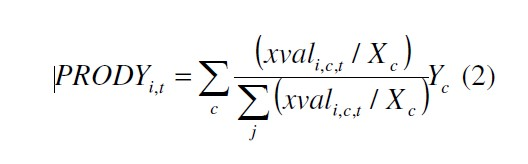

This is a measure calculated as the GDP per
capita of countries that produce it, weighted by their revealed comparative advantage in
that product. As mentioned above, Hausmann Hwang & Rodrik use this product-level variable to calculate the level of sophistication of a country’s export basket, EXPYc,t as
the PRODYi,t for each component of the country’s export basket weighted by its share.

In [1]:
def calc_prody(data,pais_col,prod_col,anio_col,export_col,rcapt_col):
    
    """
      Función que calcula el valor de Prody
      Xc: equals total exports by country c, 
      Yc: equals GDP per capita of country c.

    """
    """
      Where xvali,c,t equals exports of good i by country c in year t

    """
    print('En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t')
    df_prody = pd.DataFrame(list(product(data[anio_col].unique(),data[pais_col].unique(),data[prod_col].unique())))
    df_prody.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    # df_prody = pd.merge(df_prody,data[[anio_col,pais_col,prod_col,export_col,gdp_per_capita_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_prody = pd.merge(df_prody,data[[anio_col,pais_col,prod_col,export_col,rcapt_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_prody.loc[df_prody[export_col].isnull(),export_col] = 0

    print('Se hace el calculo de RCA')

    df_prody['Xcpt'] = df_prody[export_col]
    df_prody['Xct'] = df_prody.groupby([pais_col, anio_col])[export_col].transform(sum)
    df_prody['Xpt'] = df_prody.groupby([prod_col, anio_col])[export_col].transform(sum)
    df_prody['Xt'] = df_prody.groupby([anio_col])[export_col].transform('sum')
    # df_prody['Yc'] = df_prody.groupby([pais_col, anio_col])[gdp_per_capita_col]
    # df_prody['Yc'] = df_prody[gdp_per_capita_col]
    df_prody['Yct'] = pd.Series([2000 for x in range(len(df_prody.index))])


    # df_prody['RCAcpt'] = (df_prody['Xcpt']/df_prody['Xct'])/(df_prody['Xpt']/df_prody['Xt']) #--> ecuación de las RCA
    df_prody['RCAcpt'] = df_prody[rcapt_col]
    df_prody.loc[df_prody['RCAcpt'].isnull(),'RCAcpt'] = 0

    print('Se hace el calculo de Yt')

    df_prody['Yt']= df_prody.groupby([anio_col])[['Yct']].transform('sum')
    df_prody['RCApt'] = df_prody.groupby([prod_col,anio_col])[['RCAcpt']].transform('sum')
    # df_prody['PRODY'] = df_prody['RCAcpt']*df_prody['Yt']


    """
    Me agrada este
    """
    print('Se hace el calculo de PRODY')

    # df_prody['prodycit'] = df_prody['RCAcpt']*df_prody['Yct']
    # df_prody['PRODY'] = df_prody.groupby([prod_col,anio_col])[['prodycit']].transform('sum')

    df_prody['PRODY']   = df_prody['RCApt']*df_prody['Yt']

    #retiro las propiedadades del dataframe 
    df_prody.drop(['Xcpt','Xct','Xpt','Xt','Yc'],axis=1,inplace=True,errors='ignore')

    print('Prody Listo! ')

    return df_prody



In [2]:
# df_prody = calc_prody(data=df_merge,pais_col='country_name',prod_col='product_name',anio_col='year',export_col='export_value',gdp_per_capita_col='gdp_per_capita').copy()
df_prody = calc_prody(data=df_rca,pais_col='country_name',prod_col='product_name',anio_col='year',export_col='export_value',rcapt_col='RCAcpt').copy()
# df_prody.sample(n=10)
#df_prody.head(10)

NameError: ignored

In [51]:
df_prody.sample(n=5)

,year,country_name,product_name,export_value,RCAcpt,Yct,Yt,PRODY
3122310,2005,India,"Hydrometers and similar floating instruments, thermometers, pyrometers, barometers, hygrometers and psychrometers, recording or not",5353829.00,0.24,2000,601128000,485.85
2430914,2003,Bahrain,Cyclic hydrocarbons,16579.00,0.00,2000,601128000,2.03
3052364,2005,China,"Tableware, kitchenware, other household articles and toilet articles; of porcelain or china",1316594048.00,5.21,2000,601128000,10427.91
5192643,2012,Fiji,"Signalling, safety or traffic control equipment; for railways, tramways, roads, inland waterways, parking facilities, port installations, airfields, excluding those of heading no. 8608",0.00,0.00,2000,601128000,0.00
6212451,2015,Portugal,"Toys; wheeled, designed to be ridden by children (eg tricycles, scooters, pedal cars), dolls' carriages",0.00,0.00,2000,601128000,0.00


In [ ]:
df_prody[(df_prody['product_name']=='Meat of swine; fresh, chilled or frozen')].sort_values(by=['year'],ascending=True)[['product_name','export_value','year','RCAcpt','RCApt','PRODY']].copy()

# (df_prody['country_name']=='Ecuador') & 

##Cálculo de EXPY


This product-level measure of sophistication is then used to measure the sophistication of
a country’s export basket as a whole. The authors call this measure EXPY. EXPY is simply the
PRODY of each good (i) that country c exports, weighted by that good’s share in the country’s
export basket (Xc). It represents the income level associated with a country’s overall export
package.

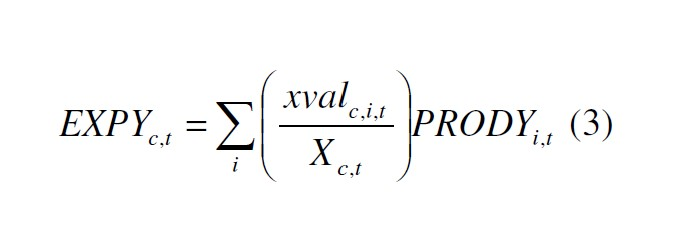

In [75]:
def calc_expy(data,pais_col,prod_col,anio_col,export_col,prody_col):
    """
    Función para el cálculo de EXPY c,t
    """
    print('En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t')
    df_expy = pd.DataFrame(list(product(data[anio_col].unique(),data[pais_col].unique(),data[prod_col].unique())))
    df_expy.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')

    df_expy = pd.merge(df_expy,data[[anio_col,pais_col,prod_col,export_col, prody_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_expy.loc[df_expy[export_col].isnull(),export_col] = 0

    """
    Calculo de propiedades
    """
    print('Se procede al calculo de propiedades')

    # df_expy['Xct'] = df_expy.groupby([pais_col,anio_col])[export_col].transform('sum')
    # df_expy['Xct'] =  df_expy.groupby([prod_col,anio_col])[export_col].transform('sum')
    # df_expy['XVALcit'] = df_expy[export_col]
    df_expy['XVALcit'] =df_expy.groupby([pais_col, anio_col])[export_col].transform(sum)
    df_expy['Xct'] = df_expy.groupby([pais_col, anio_col])[export_col].transform(sum)
    df_expy['cociente'] = df_expy['XVALcit']/df_expy['Xct']
    df_expy['Xvalcociente'] = df_expy.groupby([pais_col, anio_col])['cociente'].transform(sum)

    """ 
    Ecuación de EXPYc,t
    """
    # df_expy['EXPY_int']= (df_expy['XVALcit']/df_expy['Xct'])*df_expy[prody_col]
    # df_expy['EXPY_int']= df_expy.groupby([anio_col])[prody_col].transform(sum)
    df_expy['EXPY_int']= df_expy['cociente']*df_expy[prody_col]


    # df_expy['EXPY'] = df_expy['Xvalcociente']*df_expy['EXPY_int']
    df_expy['EXPY'] = df_expy.groupby([pais_col,anio_col])['EXPY_int'].transform('sum')
    # df_expy.drop(['EXPY_int'],axis=1,inplace=True,errors='ignore')


    return df_expy

In [76]:
df_expy = calc_expy(data=df_prody,pais_col='country_name',prod_col='product_name',anio_col='year',export_col='export_value', prody_col='PRODY').copy()
df_expy.head(8)

En esta parte de la funcion se crea la combinación de producto-i, país-c y tiempo-t
Se procede a fusionar los datos
Se procede al calculo de propiedades


,year,country_name,product_name,export_value,PRODY,XVALcit,Xct,cociente,Xvalcociente,EXPY_int,EXPY
0,1995,Aruba,"Horses, asses, mules and hinnies; live",18008.00,269.81,610752251.00,610752251.00,1.00,1242.00,269.81,281536.70
1,1995,Aruba,Bovine animals; live,0.00,0.00,610752251.00,610752251.00,1.00,1242.00,0.00,281536.70
2,1995,Aruba,Swine; live,0.00,0.00,610752251.00,610752251.00,1.00,1242.00,0.00,281536.70
3,1995,Aruba,Sheep and goats; live,0.00,0.00,610752251.00,610752251.00,1.00,1242.00,0.00,281536.70
4,1995,Aruba,"Poultry; live, fowls of the species gallus domesticus, ducks, geese, turkeys and guinea fowls",0.00,0.00,610752251.00,610752251.00,1.00,1242.00,0.00,281536.70
5,1995,Aruba,"Animals, n.e.s. in chapter 01; live",2336.00,97.31,610752251.00,610752251.00,1.00,1242.00,97.31,281536.70
6,1995,Aruba,Meat of bovine animals; fresh or chilled,0.00,0.00,610752251.00,610752251.00,1.00,1242.00,0.00,281536.70
7,1995,Aruba,Meat of bovine animals; frozen,0.00,0.00,610752251.00,610752251.00,1.00,1242.00,0.00,281536.70


In [77]:
# df_expy_ec=df_expy[ (df_expy['country_name']=='Ecuador') ].sort_values(by=['year'],ascending=True)[['product_name','export_value','year','PRODY','EXPY_int','EXPY']].copy()
df_expy.sample(n=8)

,year,country_name,product_name,export_value,PRODY,XVALcit,Xct,cociente,Xvalcociente,EXPY_int,EXPY
7620782,2020,French Guiana,Vehicles; public transport passenger type,0.00,0.00,0.00,0.00,NaN,0.00,NaN,0.00
3504513,2006,Poland,Stainless steel; flat-rolled products of width less than 600mm,14427914.00,676.32,106466797800.00,106466797800.00,1.00,1242.00,676.32,2940900.43
6322262,2016,Argentina,"Inner tubes, of rubber",18821.00,9.16,57192269533.00,57192269533.00,1.00,1242.00,9.16,3368569.42
5622869,2013,Sudan,"Acids; polycarboxylic acids, their anhydrides, halides, peroxides and peroxy-acids; their halogenated, sulphonated, nitrated or nitrosated derivatives",0.00,0.00,7425431496.00,7425431496.00,1.00,1242.00,0.00,4080289.48
7075956,2018,Mongolia,Sodium hydroxide (caustic soda); potassium hydroxide (caustic potash) peroxides of sodium or potassium,0.00,0.00,7178914650.00,7178914650.00,1.00,1242.00,0.00,3884979.37
1680234,2000,Norfolk Island,Ball or roller bearings,0.00,0.00,1087354.00,1087354.00,1.00,1242.00,0.00,3320283.53
1441251,1999,Tokelau,Cork; articles of natural cork,0.00,0.00,13608184.00,13608184.00,1.00,1242.00,0.00,3166761.69
4167000,2008,Vietnam,Maize (corn),5238512.00,99.65,61976348609.00,61976348609.00,1.00,1242.00,99.65,3541474.02


In [78]:
# df_expy_ec['EXPY'].unique()

df_latam=df_expy.loc[df_expy['country_name'].isin(['Ecuador','Argentina','Brazil','Venezuela','Colombia','Bolivia','Peru'])].copy()
df_latam=df_latam[['year','country_name','PRODY','EXPY_int','EXPY']].copy()
# df_latam=df_latam(['year','country'])['EXPY'].unique()

df_latam=df_latam.drop_duplicates(subset = "EXPY").copy()
df_latam=df_latam.sort_values(by=['year'],ascending=False)
df_latam= df_latam.pivot(index="year", columns="country_name", values="EXPY")
# df_latam.columns = df_latam.columns.droplevel('country_name')
df_latam=df_latam.reset_index()
# df_latam.reset_index(drop=True, inplace=True)
# df_latam.drop(['country_name'])

df_latam.head(6)

country_name,year,Argentina,Bolivia,Brazil,Colombia,Ecuador,Peru,Venezuela
0,1995,3455181.77,6749863.10,2920574.96,1957201.12,2081275.45,5977619.02,1277928.20
1,1996,3180714.03,6199325.42,3014580.76,1889346.75,2128414.83,5896289.49,1127950.47
2,1997,3066281.76,5604609.56,2829054.40,1937056.42,2199998.77,6013940.65,1222421.04
3,1998,3271406.82,5537673.19,2918530.05,2103449.31,2517621.18,5762113.49,1606056.18
4,1999,3801562.85,5884390.30,3189598.26,2088569.23,2314100.39,5972274.80,1383212.44
5,2000,3690692.18,7453857.30,3143087.10,2159507.01,2423352.05,6357085.03,1099225.16


In [79]:
## Para comparar con los datos del articulo de Hausmman y Klinger:

out = df_latam['year'].isin(range(1995,2009))

#filter dataframe
filtered_df = df_latam[out]

filtered_df.head()

country_name,year,Argentina,Bolivia,Brazil,Colombia,Ecuador,Peru,Venezuela
0,1995,3455181.77,6749863.10,2920574.96,1957201.12,2081275.45,5977619.02,1277928.20
1,1996,3180714.03,6199325.42,3014580.76,1889346.75,2128414.83,5896289.49,1127950.47
2,1997,3066281.76,5604609.56,2829054.40,1937056.42,2199998.77,6013940.65,1222421.04
3,1998,3271406.82,5537673.19,2918530.05,2103449.31,2517621.18,5762113.49,1606056.18
4,1999,3801562.85,5884390.30,3189598.26,2088569.23,2314100.39,5972274.80,1383212.44


<Figure size 1008x432 with 0 Axes>

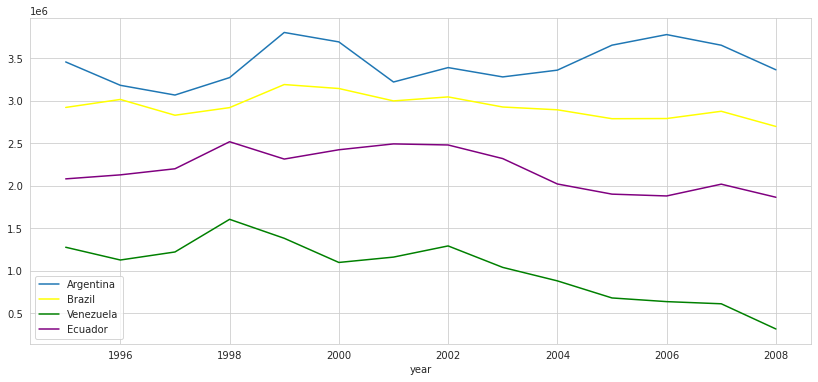

In [80]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sb

plt.figure(figsize=(14, 6))

ax = plt.gca()

filtered_df.plot(kind='line',x='year', y='Argentina', ax=ax)
# filtered_df.plot(kind='line',x='year', y='Bolivia', color='pink', ax=ax)
filtered_df.plot(kind='line',x='year', y='Brazil', color='yellow', ax=ax)
filtered_df.plot(kind='line',x='year', y='Venezuela', color='green', ax=ax)
filtered_df.plot(kind='line',x='year', y='Ecuador', color='purple', ax=ax)
# filtered_df.plot(kind='line',x='year', y='Peru', color='brown', ax=ax)



plt.show()

